# Masking Land Cover with Geodatacoast

## Load packages

In [12]:
import datacube
from datacube.utils import masking 
from odc.ui import with_ui_cbk
import matplotlib.pyplot as plt
import xarray as xr
from scipy import ndimage
import numpy as np


import sys
sys.path.insert(1, '../Tools/')
from datacube.utils.cog import write_cog
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.landcover import plot_land_cover
from dea_tools.spatial import xr_rasterize


## Load data

In [13]:
# connect to datacube
dc = datacube.Datacube(app="")

In [14]:
# define central coords for area of interest
area_name = 'southern_vic'
point_x, point_y =( -38.9452, 146.2559)

# select sise of area (check on map below that you are happy with extent before proceeding)
lat = (point_x-0.3, point_x+0.3)
lon = (point_y-0.3, point_y+0.3)

# display AOI on map
display_map(x=lon, y=lat)

In [15]:
# specify the parameters to pass to the load query
query = {
    "x": lon,
    "y": lat,
    "output_crs": "EPSG:3577",
    'resolution': (-25, 25),
    "group_by": "solar_day",
    }

# load geocoast data
geodatacoast = dc.load(product="geodata_coast_100k",
         **query)

# load land cover data 
landcover = dc.load(product="ga_ls_landcover_class_cyear_2", measurements='level4', time ='2020',
         **query)

## Define the mask.

For reference, in the geodata_coast_100k layer: 
* 0 = ocean
* 1 = island
* 2 = mainland


In [16]:
# 1 represents ocean and 0 represent land
mask_land_0 = xr.ones_like(landcover.level4).where(geodatacoast.land.isel(time=0) < 1, 0)

# 0 represents ocean and 1 represent land
mask_land_1 = xr.ones_like(landcover.level4).where(geodatacoast.land.isel(time=0) >= 1, 0)

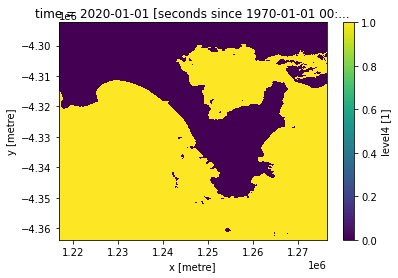

In [17]:
mask_land_0.plot()

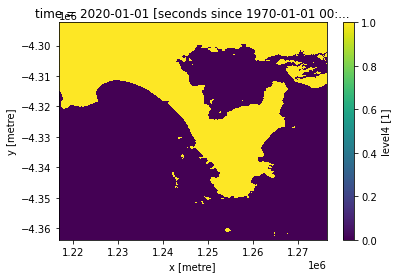

In [18]:
mask_land_1.plot()

## now it's time to buffer out the ocean
this library has lots of different fuctions for dialtion and erossion : https://docs.scipy.org/doc/scipy/reference/ndimage.html. for starters we will try scipy.ndimage.binary_erosion(), and arbitarily errode by one Km (40 * 25m pixles)

### Binary erosion


In [19]:
# remove time dimmesion by selecting first time index. make it an xarray for easy plotting.
binerosion_buff = xr.DataArray(ndimage.binary_erosion(mask_land_0.isel(time=0), iterations=40))

# make it right side up 
binerosion_buff = binerosion_buff.isel(dim_0=slice(None,None,-1))

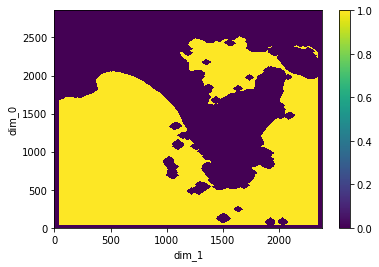

In [20]:
binerosion_buff.plot()

#It's upside down I don't know why. and Why is is buddering around the edge and how do we top that!! we wi;
#its the right way up now but has a boarder??? WHYYYYYYYYYYY

In [21]:
# data = landcover.level4.isel(time=0)
# lc_binerosion_masked = np.ma.masked_where(binerosion_buff == 1, data)
# mask = xr_rasterize(binerosion_buff, landcover)
# lc_binerosion_masked = landcover.where(mask)
# mask = np.where(binerosion_buff, np.NaN, 1)

# mask = xr.DataArray(np.where(binerosion_buff, np.NaN, 1))

# data = landcover.level4
# masked_data = data * mask


In [23]:
# mask.plot()

In [24]:
landcover

<xarray.Dataset>
Dimensions:      (time: 1, y: 2855, x: 2384)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01
  * y            (y) float64 -4.292e+06 -4.292e+06 ... -4.364e+06 -4.364e+06
  * x            (x) float64 1.217e+06 1.217e+06 ... 1.276e+06 1.276e+06
    spatial_ref  int32 3577
Data variables:
    level4       (time, y, x) uint8 14 33 28 14 14 14 ... 101 101 101 101 101
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Binary dilation

In [25]:
#remove time dimmesion by selecting first time index. make it an xarray for easy plotting
bindilation_buff = xr.DataArray(np.flipud(ndimage.binary_dilation(mask_land_1, iterations=40)))

bindilation_buff

<xarray.DataArray (dim_0: 1, dim_1: 2855, dim_2: 2384)>
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Dimensions without coordinates: dim_0, dim_1, dim_2

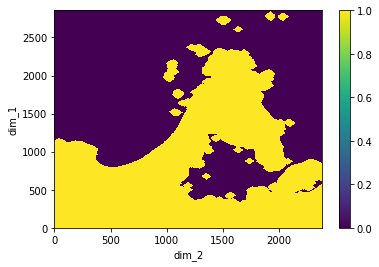

In [26]:
bindilation_buff.plot()

In [40]:
landcover['masked_level4'] = xr.DataArray(np.where(bindilation_buff, landcover.level4, np.zeros_like(landcover.level4)), dims=('time', 'y', 'x'))

#OKAY I had to make it use numpy becasue numpy is faster. 


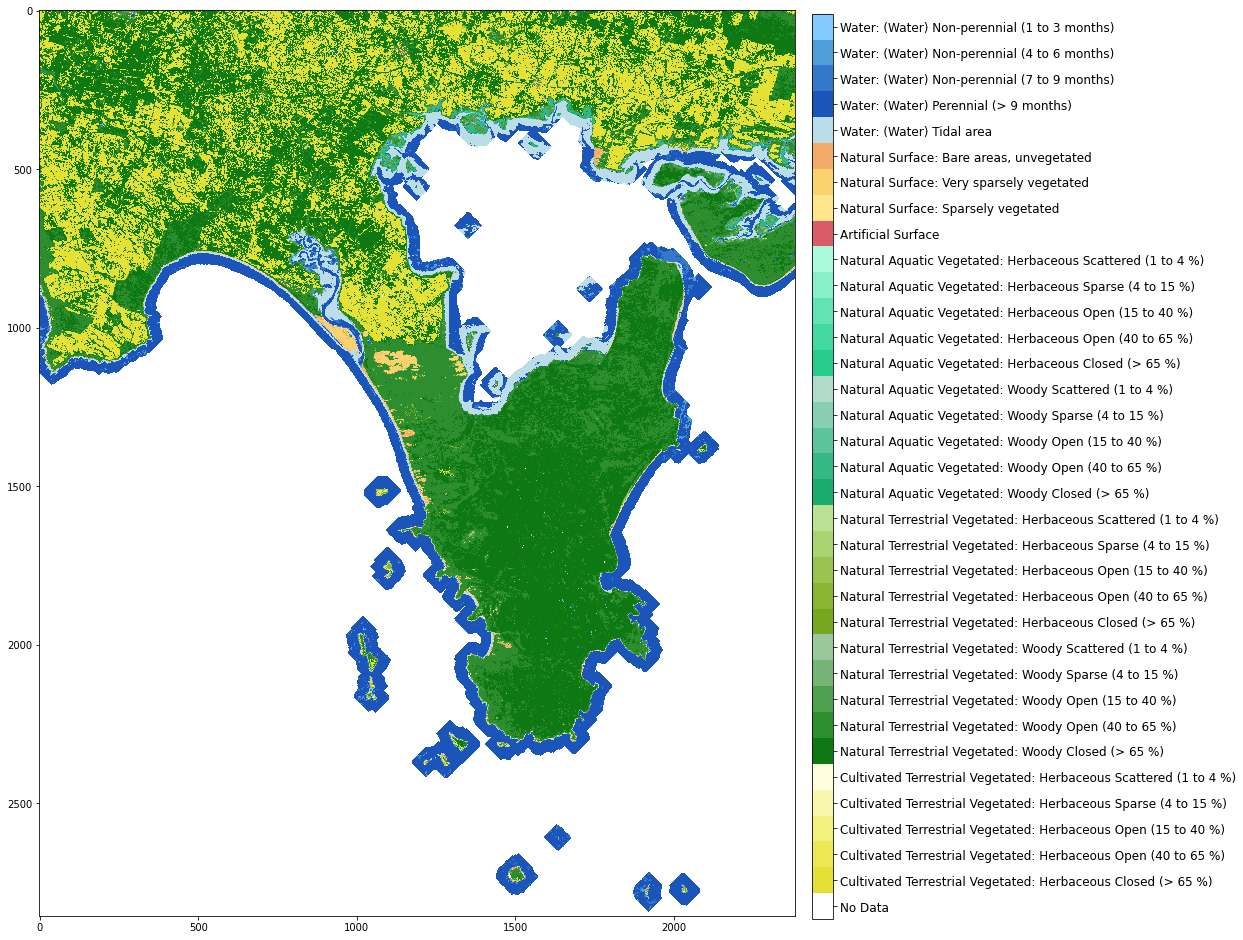

In [43]:
plot_land_cover(landcover.masked_level4, measurement='level4', year='2010')

In [41]:
landcover

<xarray.Dataset>
Dimensions:        (time: 1, y: 2855, x: 2384)
Coordinates:
  * time           (time) datetime64[ns] 2020-01-01
  * y              (y) float64 -4.292e+06 -4.292e+06 ... -4.364e+06 -4.364e+06
  * x              (x) float64 1.217e+06 1.217e+06 ... 1.276e+06 1.276e+06
    spatial_ref    int32 3577
Data variables:
    level4         (time, y, x) uint8 14 33 28 14 14 14 ... 101 101 101 101 101
    masked_level4  (time, y, x) uint8 14 33 28 14 14 14 14 15 ... 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref